In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tqdm
import pickle

In [82]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        



In [83]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#

# SectionB_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
input_path = '../input'
training_images_filepath = 'SectionB_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = 'SectionB_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = 'SectionB_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = 'SectionB_dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


In [84]:

Y_train = np.array(y_train)[:30000]
X_train = np.array(x_train)[:30000]

Y_test = np.array(y_test)[:3000]
X_test = np.array(x_test)[:3000]

Y_val = np.array(y_train)[3001:6001]
X_val = np.array(x_train)[3001:6001]


X_test = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)




In [85]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape

((30000, 784), (30000,), (3000, 784), (3000,), (3000, 784), (3000,))

In [86]:
def loss_plot(training_loss, validation_loss, activation_function, weight_initialization):
    epochs = range(0, len(training_loss) * 10, 10)  # x-axis values in steps of 10
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(f'Loss vs Epoch for {activation_function} activation with {weight_initialization} initialization')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [87]:
class NeuralNetwork:
    def __init__(self, N, neurons_per_layer, lr, activation_function, epochs, batch_size, weights_init):
        self.layer_size = N
        self.neurons_per_layers = neurons_per_layer   
        self.learning_rate = lr
        self.activation_function = activation_function
        self.weights_init = weights_init
        self.epochs = epochs
        self.batch_size = batch_size

        self.weights = []
        self.biases = []
        self.initialize_weights_bias()

    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def fit(self, X, Y_encoded, X_val, Y_val_encoded, X_test, Y_test_encoded):
        train_loss = []
        val_loss = []
    
        # X_val = X_val.reshape(X_val.shape[0], -1)   
        # X_test = X_test.reshape(X_test.shape[0], -1)
        # Y_val_encoded = np.eye(self.neurons_per_layers[-1])[Y_val]
        # for i in range(self.epochs):
        for i in tqdm.tqdm(range(self.epochs)):
            for j in range(0, X.shape[0], self.batch_size):
                X_batch = X[j:j+self.batch_size]
                Y_batch = Y_encoded[j:j+self.batch_size]

                X_batch = X_batch.reshape(X_batch.shape[0], -1)  # Flatten each image
                Z_values, activations = self.feed_forward(X_batch)
                self.backward_propagation(X_batch, Y_batch, Z_values, activations)

            if(i%10 == 0):
                train_loss.append(self.loss(Y_encoded, self.predict_proba(X)))
                val_loss.append(self.loss(Y_val_encoded, self.predict_proba(X_val)))

        loss_plot(train_loss,val_loss,self.activation_function,self.weights_init)


    def predict(self, X):
        X = X.reshape(X.shape[0], -1) 
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)
    
    def predict_proba(self, X):
        X = X.reshape(X.shape[0], -1) 
        _, activations = self.feed_forward(X)
        return activations[-1]
    
    def score(self, X, Y):
        predictions = self.predict(X)
        return np.mean(predictions == Y)

    #activation functions
    def softmax(self,x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values/np.sum(exp_values, axis=1, keepdims=True)
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def tanh(self,x):
        return np.tanh(x)

    def relu(self,x):
        return np.maximum(0,x)
    
    def leaky_relu(self,x):
        return np.maximum(0.01*x,x)
    
    def activation_func(self,x):
        if(self.activation_function == 'sigmoid'):
            return self.sigmoid(x)
        elif(self.activation_function == 'relu'):
            return self.relu(x)
        elif(self.activation_function == 'tanh'):
            return self.tanh(x)
        elif(self.activation_function == 'leaky_relu'):
            return self.leaky_relu(x)

    def initialize_weights_bias(self):
        for i in range(1, self.layer_size):
            input_layer_size = self.neurons_per_layers[i - 1]
            output_layer_size = self.neurons_per_layers[i]
            if self.weights_init == 'zero':
                self.weights.append(np.zeros((input_layer_size, output_layer_size)))  # Initialize weights to zero

            elif self.weights_init == 'random':
                self.weights.append(np.random.rand(input_layer_size, output_layer_size) * 0.01)  # Small random values

            elif self.weights_init == 'normal':
                self.weights.append(np.random.randn(input_layer_size, output_layer_size) * np.sqrt(2 / input_layer_size))  # Xavier initialization

            self.biases.append(np.zeros((1, output_layer_size)))
            
    def feed_forward(self, X):
        activations = [X]
        Z = []
        for i in range(self.layer_size-1):
            val = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            Z.append(val)
            # activations.append(self.activation_function(Z[-1]))
            if(i<self.layer_size-2):
                activations.append(self.activation_func(val))
            else:
                activations.append(self.softmax(val))

        return Z, activations
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))

    def relu_derivative(self, x):
        return np.where(x>0,1,0)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def leaky_relu_derivative(self, x):
        return np.where(x>0,1,0.01)

    def activation_function_derivative(self, z):
        if self.activation_function == 'sigmoid':
            return self.sigmoid_derivative(z) 
        elif self.activation_function == 'relu':
            return self.relu_derivative(z)  
        elif self.activation_function == 'tanh':
            return self.tanh_derivative(z)  
        elif self.activation_function == 'leaky_relu':
            return self.leaky_relu_derivative(z) 

    
    def backward_propagation(self, X, Y, Z_values, activations):
        m = X.shape[0]
        dw = [None]*len(self.weights)
        db = [None]*len(self.biases)

        dz = activations[-1] - Y
        for i in range(len(self.weights)-1, -1, -1):
            dw[i] = np.dot(activations[i].T,dz)/m
            db[i] = np.sum(dz, axis=0,keepdims=True)/m

            if i>0:
                dz = np.dot(dz, self.weights[i].T)*self.activation_function_derivative(Z_values[i-1])

        #weight are being updated here only
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate*dw[i]
            self.biases[i] -= self.learning_rate*db[i]

        

run this before pkl run task

In [88]:
N = 6
neurons_per_layer = [784,256,128,64,32,10]

Y_train_one_hot = np.eye(neurons_per_layer[-1])[Y_train]
Y_test_one_hot = np.eye(neurons_per_layer[-1])[Y_test]
Y_val_one_hot = np.eye(neurons_per_layer[-1])[Y_val]


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


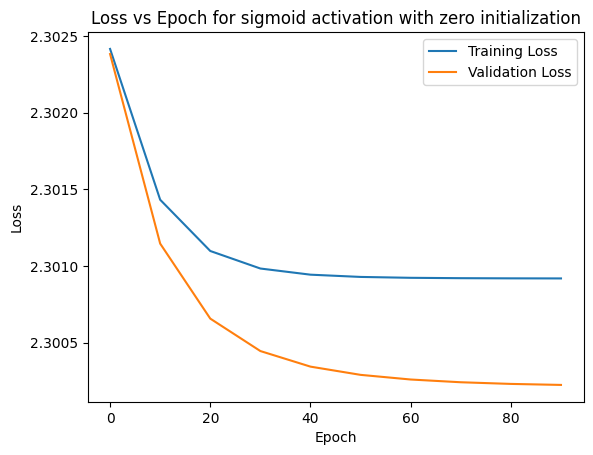

Accuracy for sigmoid and zero: 0.11333333333333333


100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


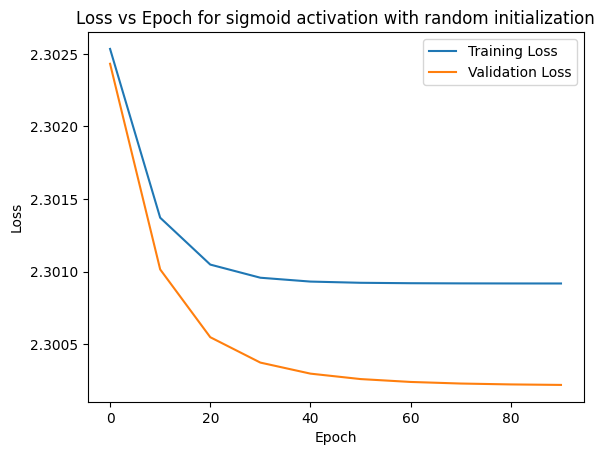

Accuracy for sigmoid and random: 0.11333333333333333


100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


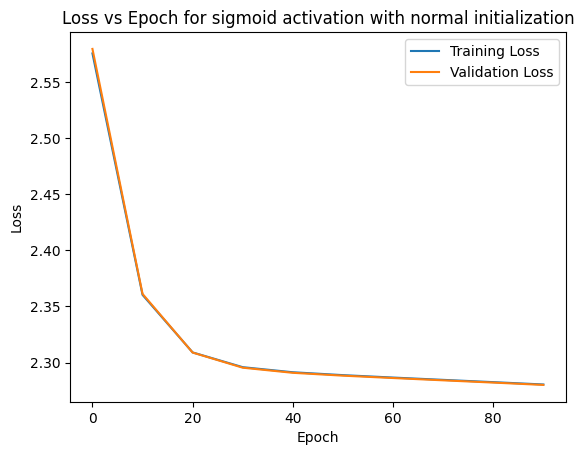

Accuracy for sigmoid and normal: 0.11333333333333333


100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


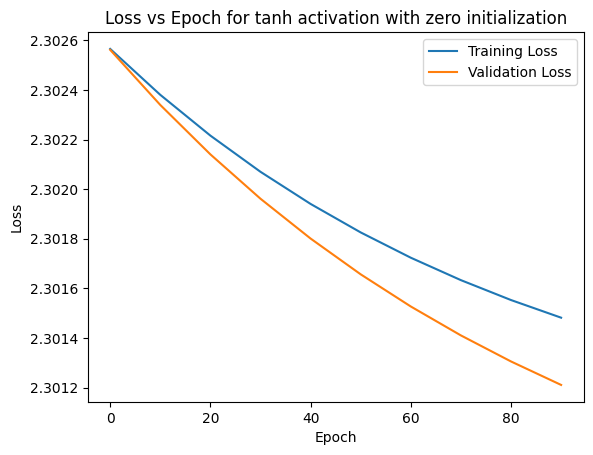

Accuracy for tanh and zero: 0.11333333333333333


100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


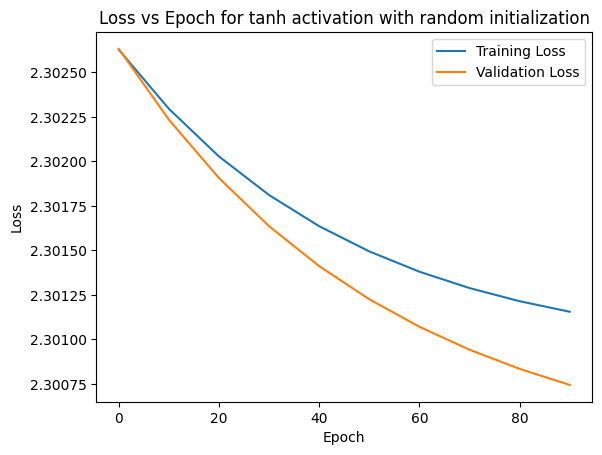

Accuracy for tanh and random: 0.11333333333333333


100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


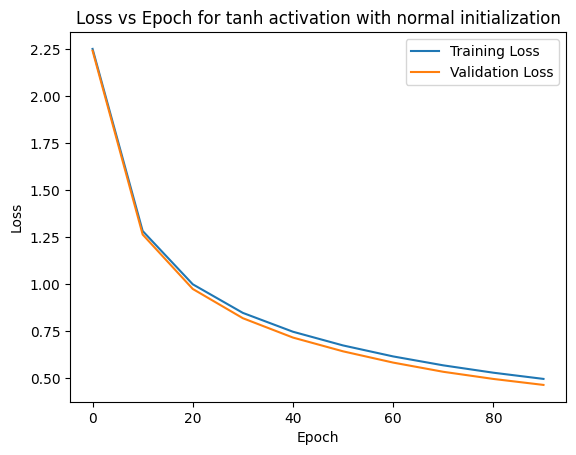

Accuracy for tanh and normal: 0.8113333333333334


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


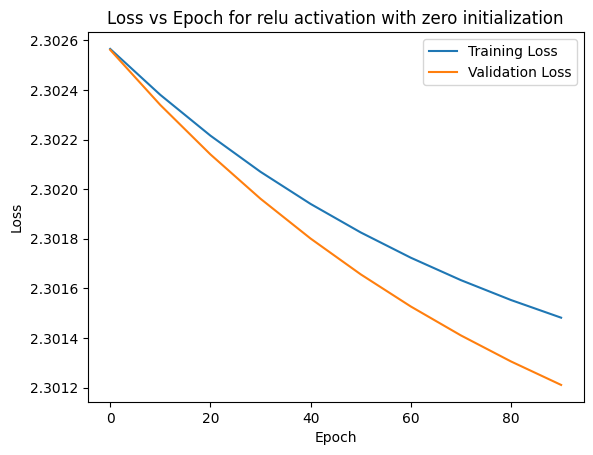

Accuracy for relu and zero: 0.11333333333333333


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


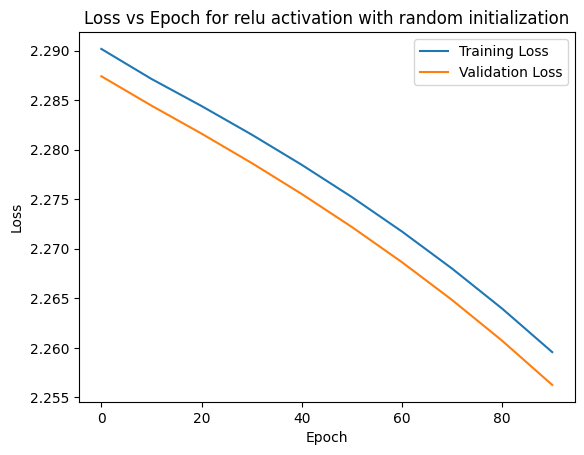

Accuracy for relu and random: 0.12433333333333334


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


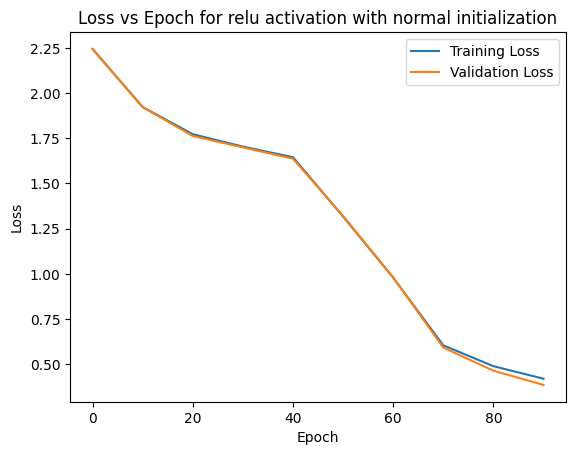

Accuracy for relu and normal: 0.86


100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


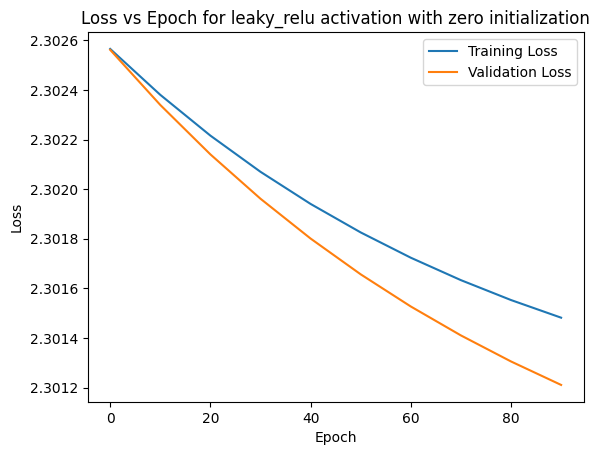

Accuracy for leaky_relu and zero: 0.11333333333333333


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


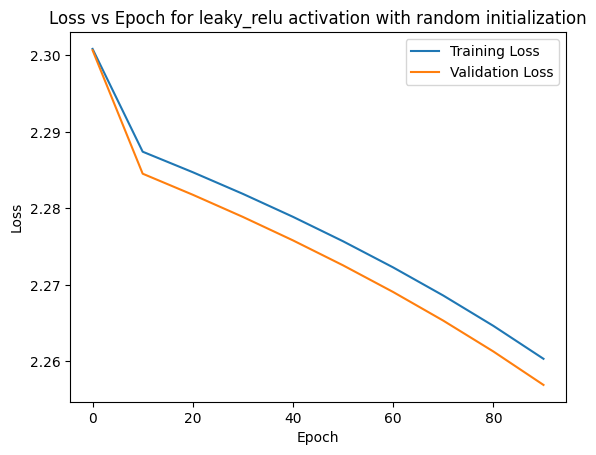

Accuracy for leaky_relu and random: 0.12233333333333334


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


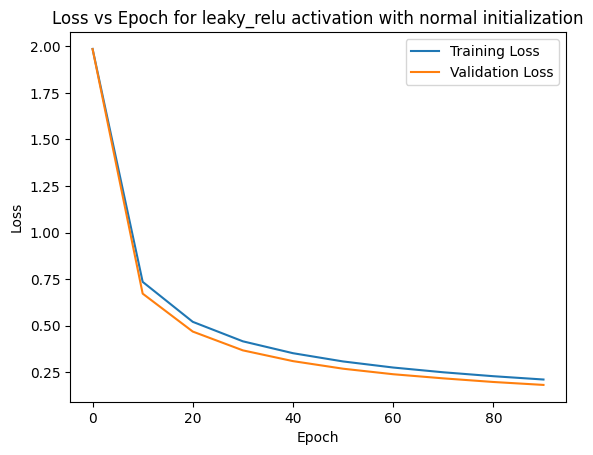

Accuracy for leaky_relu and normal: 0.8806666666666667


In [89]:

lr = 2e-3
epochs = 100
batch_size = 1024
activation_function = 'relu'
activation_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
weights_init = ['zero', 'random', 'normal']


for i in range(4):
    for j in range(3):
        
        network = NeuralNetwork(N, neurons_per_layer, lr=lr, activation_function=activation_functions[i],epochs=epochs, batch_size=batch_size, weights_init=weights_init[j])
        network.fit(X_train, Y_train_one_hot, X_val, Y_val_one_hot, X_test, Y_test_one_hot)

        predictions = network.predict(X_test)
        accuracy = np.mean(predictions == Y_test)
        print(f'Accuracy for {activation_functions[i]} and {weights_init[j]}: {accuracy}')

        #save the model in a pkl file
        
        filename = f'{activation_functions[i]}_{weights_init[j]}.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(network, file)
        


# Assuming X_train and Y_train are prepared

Pipeline for pkl models (make sure to load data before this)

In [92]:
def accuracy(X_test, Y_test, filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)

    predictions = model.predict(X_test)
    accuracy = np.mean(predictions == Y_test)

    # print(f'Accuracy for {filename}: {accuracy}')
    activation_function, weight_initialization = filename.split('_')

    print(f'Accuracy for {activation_function} activation with {weight_initialization[:-4]} initialization: {accuracy}')

In [95]:
#give codeo to import a model and use it to predict
filenames = ['sigmoid_zero.pkl', 'sigmoid_random.pkl', 'sigmoid_normal.pkl', 
             'tanh_zero.pkl', 'tanh_random.pkl', 'tanh_normal.pkl', 
             'relu_zero.pkl', 'relu_random.pkl', 'relu_normal.pkl', 
             'leakyrelu_zero.pkl', 'leakyrelu_random.pkl', 'leakyrelu_normal.pkl']

for i in range(len(filenames)):
    accuracy(X_test, Y_test, filenames[i])

Accuracy for sigmoid activation with zero initialization: 0.11333333333333333
Accuracy for sigmoid activation with random initialization: 0.11333333333333333
Accuracy for sigmoid activation with normal initialization: 0.11333333333333333
Accuracy for tanh activation with zero initialization: 0.11333333333333333
Accuracy for tanh activation with random initialization: 0.11333333333333333
Accuracy for tanh activation with normal initialization: 0.8113333333333334
Accuracy for relu activation with zero initialization: 0.11333333333333333
Accuracy for relu activation with random initialization: 0.12433333333333334
Accuracy for relu activation with normal initialization: 0.86
Accuracy for leakyrelu activation with zero initialization: 0.11333333333333333
Accuracy for leakyrelu activation with random initialization: 0.12233333333333334
Accuracy for leakyrelu activation with normal initialization: 0.8806666666666667
